In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import scipy.optimize as sco
from functools import reduce
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter

In [2]:
stocks      = {'AAPL':'Apple', 'AMZN':'Amazon', 'GOOG': 'Google', 'MSFT':'Microsoft', 'TSLA':'Tesla',  'ORCL' : 'Oracle'}
commodities = {'BTC-USD' : 'Bitcoin', 'ETH-USD' : 'Ethereum'}
instruments = {**stocks, **commodities}
tickers     = list(instruments.keys())
instruments_data = {}
N = len(tickers)

start = datetime(2017, 1, 1)
end   = datetime.now()

for ticker, instrument in instruments.items():
    print("Loading data series for instrument {} with ticker = {}".format(instruments[ticker], ticker))
    instruments_data[ticker] = DataReader(ticker, data_source = 'yahoo', start = start, end = end)

Loading data series for instrument Apple with ticker = AAPL
Loading data series for instrument Amazon with ticker = AMZN
Loading data series for instrument Google with ticker = GOOG
Loading data series for instrument Microsoft with ticker = MSFT
Loading data series for instrument Tesla with ticker = TSLA
Loading data series for instrument Oracle with ticker = ORCL
Loading data series for instrument Bitcoin with ticker = BTC-USD
Loading data series for instrument Ethereum with ticker = ETH-USD


In [3]:
for ticker, instrument in instruments.items():
    instruments_data[ticker] = instruments_data[ticker]["Adj Close"]

In [4]:
tr_days = [ len(instr) for _, instr in instruments_data.items() ] 
tr_days = pd.DataFrame(tr_days, index = tickers, columns = ["Trading Days"])
tr_days.T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Trading Days,1053,1053,1053,1053,1053,1053,1526,1526


In [5]:
tr_days_stocks_bonds = instruments_data['AAPL'].groupby([instruments_data['AAPL'].index.year]).agg('count')
tr_days_bitcoin      = instruments_data['BTC-USD'].groupby([instruments_data['BTC-USD'].index.year]).agg('count')
tr_days_palladium    = instruments_data['ETH-USD'].groupby([instruments_data['ETH-USD'].index.year]).agg('count')

tr_days_per_year = pd.DataFrame([tr_days_stocks_bonds,tr_days_bitcoin, tr_days_palladium], index = ["Stocks", "Bitcoin", "Ethereum"])
tr_days_per_year

Date,2017,2018,2019,2020,2021
Stocks,251,251,252,253,46
Bitcoin,365,365,365,362,69
Ethereum,365,365,365,362,69


### 2.5 - Merging Dataframes

In [6]:
# Merging Dataframes
data = list(instruments_data.values())
data_df = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), data).dropna()
data_df.columns = tickers
data_df

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017-01-03,27.459938,753.669983,786.140015,58.538418,43.397999,36.083473,1043.839966,9.725250
2017-01-04,27.429203,757.179993,786.900024,58.276497,45.397999,36.261311,1154.729980,11.251600
2017-01-05,27.568691,780.450012,794.020020,58.276497,45.349998,36.167709,1013.380005,10.254400
2017-01-06,27.876030,795.989990,806.150024,58.781628,45.801998,35.989861,902.200989,10.254700
2017-01-09,28.131361,796.919983,806.650024,58.594547,46.256001,36.532753,902.828003,10.325600
...,...,...,...,...,...,...,...,...
2021-03-04,120.129997,2977.570068,2049.090088,226.729996,621.440002,65.610001,48561.167969,1541.914307
2021-03-05,121.419998,3000.459961,2108.540039,231.600006,597.950012,69.970001,48927.304688,1533.275024
2021-03-08,116.360001,2951.949951,2024.170044,227.389999,563.000000,72.160004,52246.523438,1834.727905


In [7]:
tr_days_per_year = data_df['AAPL'].groupby([data_df['AAPL'].index.year]).agg('count')
tr_days_per_year = pd.DataFrame([tr_days_per_year], index = ["All instruments (merged)"])
tr_days_per_year

Date,2017,2018,2019,2020,2021
All instruments (merged),251,251,252,250,46


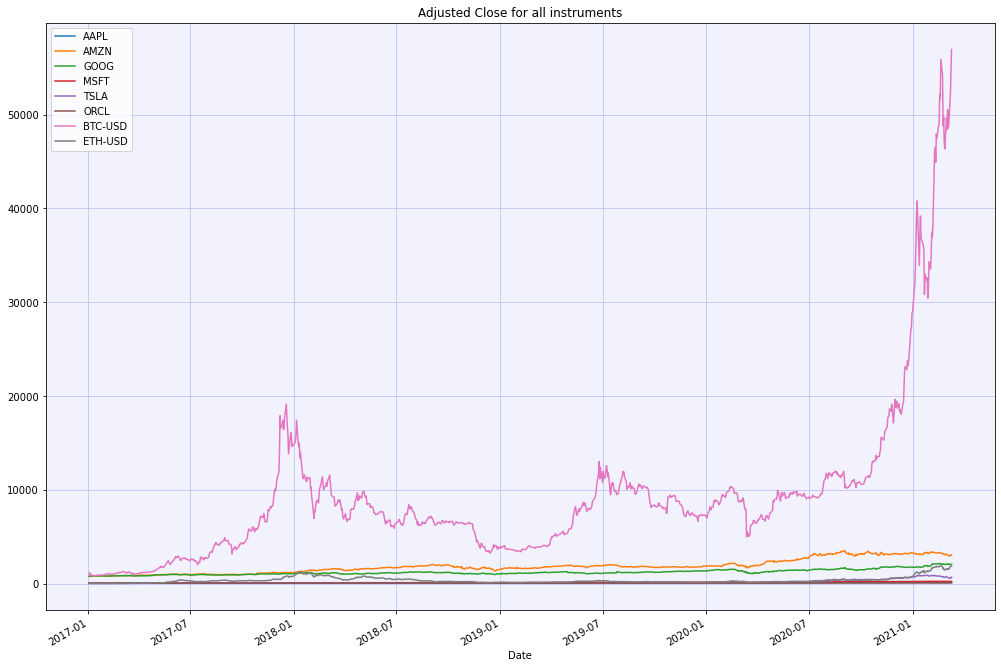

In [8]:
# Plot Adj Close together
fig, ax = plt.subplots(figsize=(17, 12))
data_df.plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for all instruments')
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))

### Calculate Descriptive Statistics

Daily
A “better” solution, though, would be to plot the information we actually want: the stock’s returns. This involves transforming the data into something more useful for our purposes. There are multiple transformations we could apply

Simple Returns : One transformation would be to consider the stock’s return since the beginning of the period of interest. In other words, we plot:$$r_t = \frac{P_t}{P_0} - 1$$
Log Returns$$r_t = ln\left(\frac{P_t}{P_0}\right)$$
Annual
$$APR = R_{nominal} = r_{N} = ln\left(\frac{P_N}{P_0}\right) = ln\left(\frac{P_N}{P_{N-1}}\cdot \frac{P_{N-1}}{P_{N-2}} \cdot ... \frac{P_1}{P_{0}}\right)$$$$APY = (1 + \frac{APR}{N})^{N} - 1 \longrightarrow R_{effective} = (1 + \frac{R_{nominal} }{N})^{N} - 1$$

### Daily Simple Returns

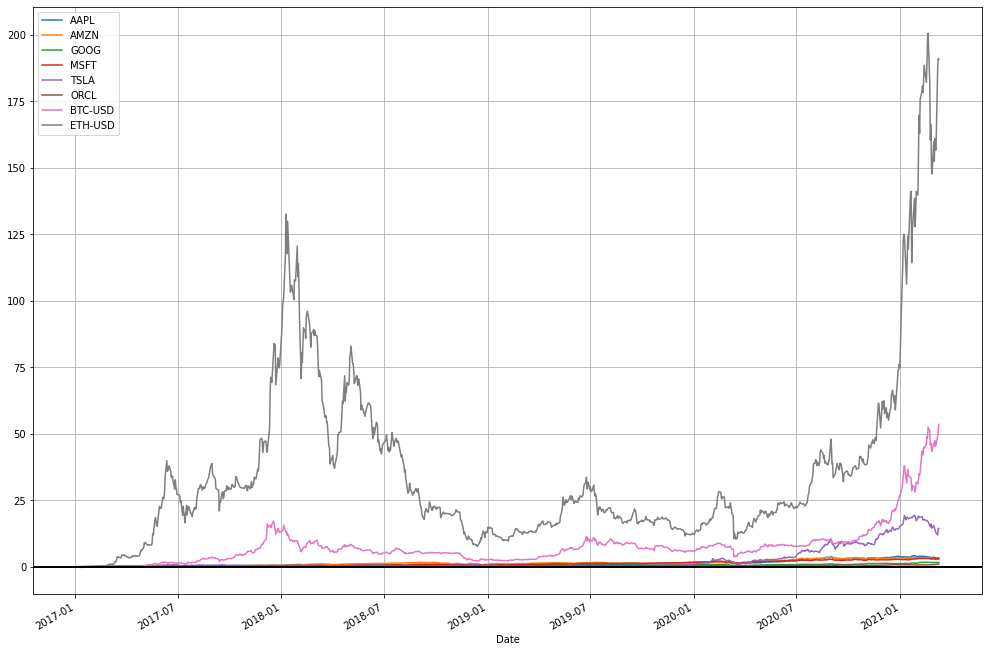

In [9]:
simple_returns = data_df.apply(lambda x: x / x[0] - 1)
simple_returns.plot(grid = True, figsize = (17, 12)).axhline(y = 0, color = "black", lw = 2)

In [10]:
# Daily Log Returns
log_returns = data_df.pct_change()
log_returns

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,-0.001119,0.004657,0.000967,-0.004474,0.046085,0.004928,0.106233,0.156947
2017-01-05,0.005085,0.030732,0.009048,0.000000,-0.001057,-0.002581,-0.122410,-0.088627
2017-01-06,0.011148,0.019912,0.015277,0.008668,0.009967,-0.004917,-0.109711,0.000029
2017-01-09,0.009160,0.001168,0.000620,-0.003183,0.009912,0.015085,0.000695,0.006914
...,...,...,...,...,...,...,...,...
2021-03-04,-0.015812,-0.009128,0.011043,-0.003647,-0.048622,-0.019429,-0.039120,-0.021537
2021-03-05,0.010738,0.007687,0.029013,0.021479,-0.037799,0.066453,0.007540,-0.005603
2021-03-08,-0.041674,-0.016168,-0.040013,-0.018178,-0.058450,0.031299,0.067840,0.196607


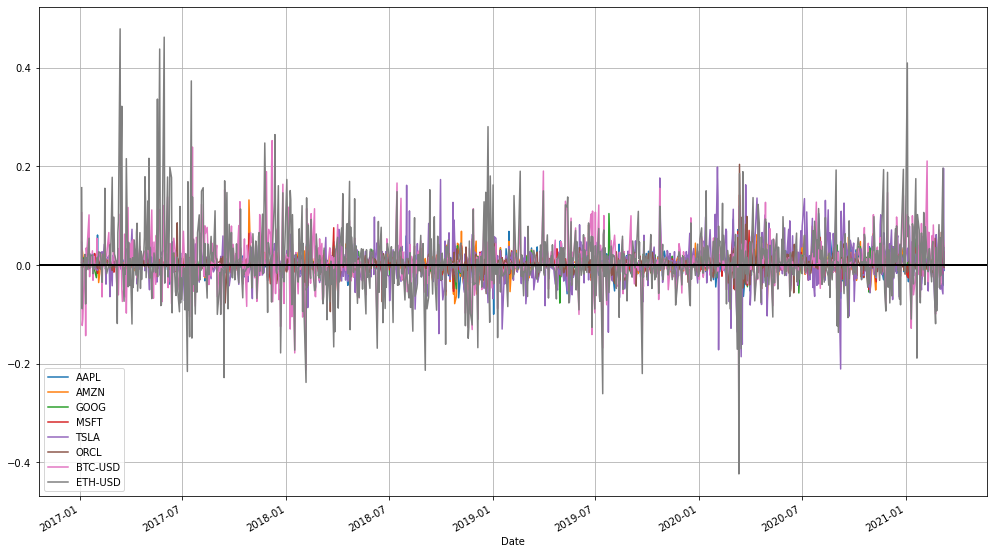

In [11]:
log_returns.plot(grid = True, figsize = (17, 10)).axhline(y = 0, color = "black", lw = 2)

### Annual : APR or $r_{nominal}$

In [12]:
APR = log_returns.groupby([log_returns.index.year]).agg('sum')
APR_avg = APR.mean()
APR

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.407928,0.460880,0.297832,0.345630,0.423272,0.231769,3.073796,5.391401
2018,-0.014373,0.315140,0.029084,0.228574,0.233929,0.002603,-1.043399,-1.124127
2019,0.671478,0.233466,0.284456,0.474615,0.350457,0.196343,0.878215,0.283864
2020,0.708341,0.640714,0.344531,0.451761,2.542280,0.297969,1.665005,2.234973
2021,-0.089687,-0.061031,0.171573,0.060642,-0.001431,0.121820,0.772760,1.119747


In [13]:
pd.DataFrame(APR_avg, columns = ['Average APR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average APR,0.336737,0.317834,0.225495,0.312244,0.709701,0.170101,1.069275,1.581171


### Annual : APY or $r_{effective}$

In [14]:
N = np.array(tr_days_per_year.T)
N_total = np.sum(N)

APY = (1  + APR / N )**N - 1
APY_avg = (1  + APR_avg /N_total  )**N_total - 1
APY

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.503201,0.584799,0.346698,0.412544,0.526405,0.260694,20.223892,206.330425
2018,-0.014270,0.370180,0.029510,0.256675,0.263417,0.002606,-0.648510,-0.675883
2019,0.955381,0.262833,0.328825,0.606678,0.419371,0.216852,1.402928,0.328040
2020,1.028587,0.896281,0.410993,0.570436,11.546489,0.346881,4.256602,8.253871
2021,-0.085863,-0.059244,0.186791,0.062476,-0.001430,0.129368,1.151879,2.023258


In [15]:
pd.DataFrame(APY_avg, columns = ['Average APY']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average APY,0.400296,0.374082,0.252913,0.366425,1.032897,0.185408,1.911683,3.854869


### Risk (Volatility Risk of returns)
Variance $\sigma^2$$$Var(R) = \sigma^2 = \frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}$$
Standard Deviation $\sigma$$$\sigma =\sqrt{\sigma^2} = \sqrt{\frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}}$$where $R_t = $ log price of instrument $i$ at the time $t$

In [16]:
# Standard Deviation
STD       = log_returns.groupby([log_returns.index.year]).agg('std') * np.sqrt(N)
STD_avg   = STD.mean()
std       = log_returns.std()
STD

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.176056,0.209632,0.153610,0.147920,0.353196,0.177480,0.929347,1.499069
2018,0.286851,0.360329,0.280793,0.282078,0.584482,0.254262,0.790631,1.094598
2019,0.261383,0.229098,0.241414,0.198285,0.493199,0.198255,0.673375,0.783045
2020,0.463384,0.384172,0.385093,0.440945,0.895174,0.407247,0.703586,0.960414
2021,0.150092,0.118716,0.145065,0.111028,0.338006,0.115887,0.438400,0.636014


In [17]:
pd.DataFrame(STD_avg, columns = ['Average STD']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average STD,0.267553,0.260389,0.241195,0.236051,0.532811,0.230626,0.707068,0.994628


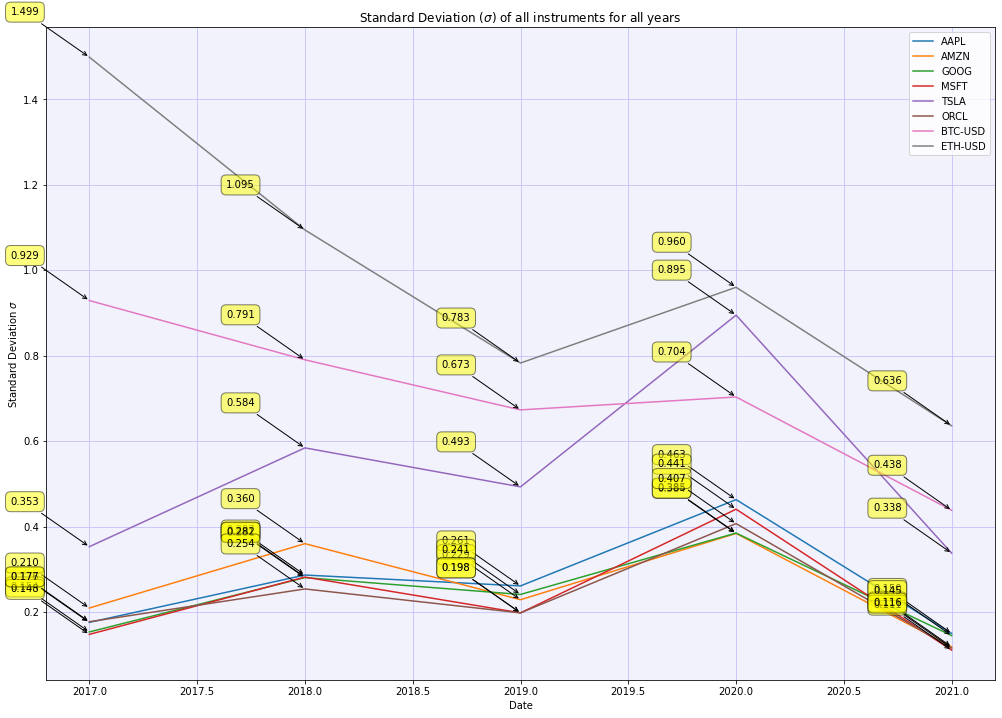

In [18]:
# Visualize standard deviation for all instruments for all years
# configuration
fig, ax = plt.subplots(figsize = (17, 12))
ax.set_title(r"Standard Deviation ($\sigma$) of all instruments for all years")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_ylabel(r"Standard Deviation $\sigma$")
ax.set_xlabel(r"Years")
STD.plot(ax = plt.gca(),grid = True)

for instr in STD:
    stds = STD[instr]
    years = list(STD.index)
    for year, std in zip(years, stds):
        label = "%.3f"%std
        plt.annotate(label, xy = (year, std), xytext=((-1)*50, 40),textcoords = 'offset points', ha = 'right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [19]:
# Variance
VAR = STD **2
VAR_avg = VAR.mean()
VAR

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Date,,,,,,,,
2017,0.030996,0.043945,0.023596,0.021880,0.124748,0.031499,0.863686,2.247206
2018,0.082283,0.129837,0.078845,0.079568,0.341619,0.064649,0.625097,1.198144
2019,0.068321,0.052486,0.058281,0.039317,0.243245,0.039305,0.453434,0.613160
2020,0.214725,0.147588,0.148297,0.194432,0.801337,0.165850,0.495034,0.922396
2021,0.022528,0.014093,0.021044,0.012327,0.114248,0.013430,0.192194,0.404514


In [20]:
pd.DataFrame(VAR_avg, columns = ['Average VAR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average VAR,0.08377,0.07759,0.066012,0.069505,0.325039,0.062947,0.525889,1.077084


### Visualize Return ($R_{effective}$) vs Risk ($\sigma$)

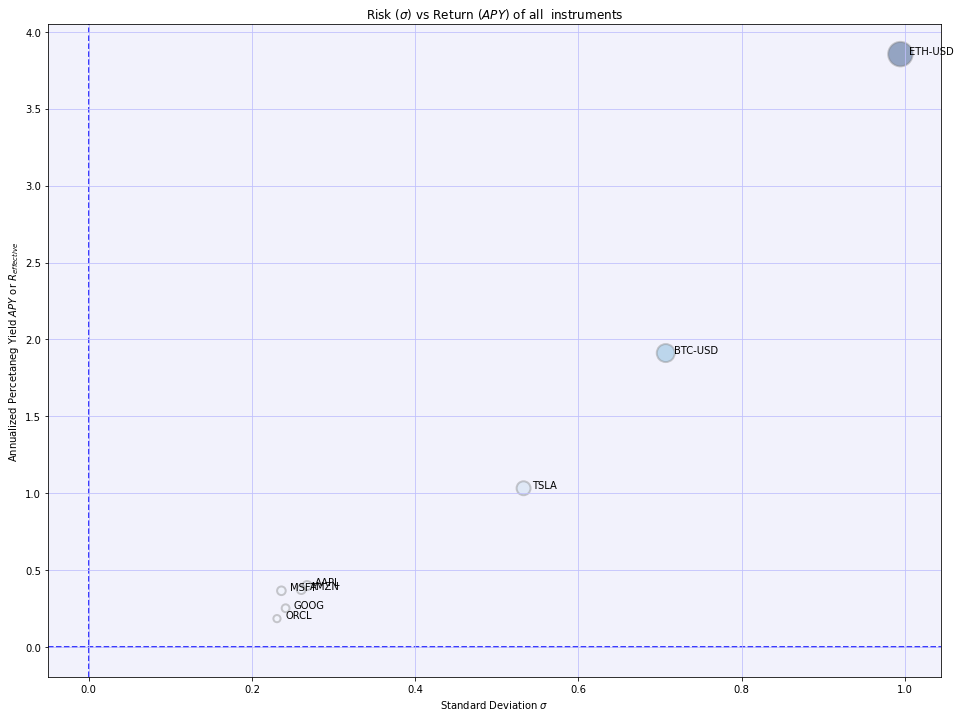

In [21]:
# configuration - generate different colors & sizes
c = [y + x for y, x in zip(APY_avg, STD_avg)]
c = list(map(lambda x : x /max(c), c))
s = list(map(lambda x : x * 600, c))

# plot
fig, ax = plt.subplots(figsize = (16,12))
ax.set_title(r"Risk ($\sigma$) vs Return ($APY$) of all  instruments")
ax.set_facecolor((0.95, 0.95, 0.99))
ax.grid(c = (0.75, 0.75, 0.99))
ax.set_xlabel(r"Standard Deviation $\sigma$")
ax.set_ylabel(r"Annualized Percetaneg Yield $APY$ or $R_{effective}$")
ax.scatter(STD_avg, APY_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors="grey", linewidth=2)
ax.axhline(y = 0.0,xmin = 0 ,xmax = 5,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
ax.axvline(x = 0.0,ymin = 0 ,ymax = 40,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')
for idx, instr in enumerate(list(STD.columns)):
    ax.annotate(instr, (STD_avg[idx] + 0.01, APY_avg[idx]))

### Calculate Additional Descriptives

In [22]:
# Configuration & Utility Function for visualization
instruments = list(log_returns.columns)
instruments

['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA', 'ORCL', 'BTC-USD', 'ETH-USD']

In [23]:
def visualize_statistic(statistic, title, limit = 0):
    # configuration
    fig, ax = plt.subplots(figsize = (17, 12))
    ax.set_facecolor((0.95, 0.95, 0.99))
    ax.grid(c = (0.75, 0.75, 0.99), axis = 'y')
    colors = sns.color_palette('Reds', n_colors = len(statistic))
    
    # visualize
    barlist = ax.bar(x = np.arange(len(statistic)), height =  statistic)
    for b, c in zip(barlist, colors):
        b.set_color(c)
    ax.axhline(y = limit, xmin = -1 ,xmax = 1,c = "blue",linewidth = 1.5,zorder = 0,  linestyle = 'dashed')

    # configure more
    for i, v in enumerate(statistic):
        ax.text( i - 0.22,v + 0.01 , str(round(v,3)), color = 'blue', fontweight='bold')
    plt.xticks(np.arange(len(statistic)), instruments)
    plt.title(r"{}for every instrument (i) against market (m) S&P500".format(title))
    plt.xlabel(r"Instrument")
    plt.ylabel(r"{} value".format(title))
    plt.show()

In [24]:
def visualize_model(alpha, beta, data, model):
    fig, axs = plt.subplots(3,3, figsize = (14, 10),  constrained_layout = True)
    # fig.tight_layout()
    idx = 0
    R_m = data["^GSPC"]
    del data["^GSPC"]
    for a, b, instr in zip(alpha, beta, data):
        i, j = int(idx / 3), idx % 3
        axs[i, j].set_title("Model : {} fitted for '{}'".format(model, instr))
        axs[i, j].set_facecolor((0.95, 0.95, 0.99))
        axs[i, j].grid(c = (0.75, 0.75, 0.99))
        axs[i, j].set_xlabel(r"Market (S&P500) log returns")
        axs[i, j].set_ylabel(r"{} log returns".format(instr))
    
        R = data[instr]
        y = a + b * R_m
        axs[i, j].scatter(x = R_m, y = R, label = 'Returns'.format(instr))
        axs[i, j].plot(R_m, y ,color = 'red', label = 'CAPM model')
        idx += 1

### Expanded CAPM (CAPM & Single-Index Model)
$$E[R] - R_f = \alpha + \beta \cdot (E[R_m] - R_f) + \epsilon$$
We calulate $\alpha, \beta$ as followed :

$\beta = \rho_{i,m}\frac{\sigma}{\sigma_m}$
$\alpha = (\overline{E[R]} - R_f) - \beta \cdot (\overline{E[R_m]} - R_f)$
We can also calculate a,b by fitting a linear-regression model (OLS) of the format:$$y = \alpha + \beta x$$

We have 1 feature $x$ : the market premium $x = (E[R_m] - R_f)$. We could have more n features $(x_1,..., x_n)$ making the prediction for the $E[R]$ more accurate (probably?)

In [25]:
# [*] Risk-Free Asset : 13 Week Tbill (^IRX). Get the most recent value
risk_free = DataReader('^IRX', data_source = 'yahoo', start = start, end = end)['Adj Close']
risk_free = float(risk_free.tail(1))

print("Risk-Free rate (Daily T-bill) = {}".format(risk_free))

Risk-Free rate (Daily T-bill) = 0.032999999821186066


### Market $R_m$ : Assume S&P500 (^GSPC)

In [26]:
# [*] Market          : S&P 500 index (^GSPC) | Yahoo Finance for index pricing, '^GSPC' is the underlying for 'SPX' options. 
market             = DataReader('^GSPC', data_source = 'yahoo', start = start, end = end)['Adj Close']
market             = market.rename("^GSPC")
market_log_returns = market.pct_change()
log_returns_total  = pd.concat([log_returns,market_log_returns], axis = 1).dropna()

# Descriptive statistics
# RETURN
log_returns_total = pd.concat([log_returns,market_log_returns], axis = 1).dropna()
APR_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('sum')
APR_avg_total     = APR_total.mean()
APR_avg_market    = APR_avg_total['^GSPC']
# RISK
STD_total         = log_returns_total.groupby([log_returns_total.index.year]).agg('std') * np.sqrt(N)
STD_avg_total     = STD_total.mean()
STD_avg_market    = STD_avg_total['^GSPC']

In [27]:
pd.DataFrame(APR_avg_total, columns = ['Average APR']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD,^GSPC
Average APR,0.336737,0.317834,0.225495,0.312244,0.709701,0.170101,1.069275,1.581171,0.120692


In [28]:
pd.DataFrame(STD_avg_total, columns = ['Average STD']).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD,^GSPC
Average STD,0.267553,0.260389,0.241195,0.236051,0.532811,0.230626,0.707068,0.994628,0.155712


In [29]:
# Calculate correlation ρ & R squared R^2 between all instruments (i) & market (m)
corr = log_returns.corrwith(market_log_returns)
r_squared = corr ** 2

pd.DataFrame(r_squared, columns = ["R squared"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
R squared,0.587343,0.382593,0.595508,0.711552,0.183392,0.48074,0.014427,0.015369


### Apply Expanded CAPM

In [30]:
# Expanded Capital Asset Pricing Model
# E[R] - R_f  = α + β * (E[R_M] - R_f) + 𝜖
# 
# INPUT :  [*] E[R] = log returns, σ = STD
# OUTPUT : [*] α,β

def CAPM():
    # Calculate average Risk Premium for every instrument  
    APR_premium        = APR_avg - risk_free
    APR_market_premium = APR_avg_market - risk_free

    # Calculate α, β
    beta  = corr *  STD_avg / STD_avg_market
    alpha = APR_premium - beta * APR_market_premium 
    return alpha, beta

alpha, beta = CAPM()

In [31]:
pd.DataFrame(alpha,  columns = ["Average α"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average α,0.188261,0.19413,0.087674,0.167108,0.548202,0.047047,0.988447,1.47873


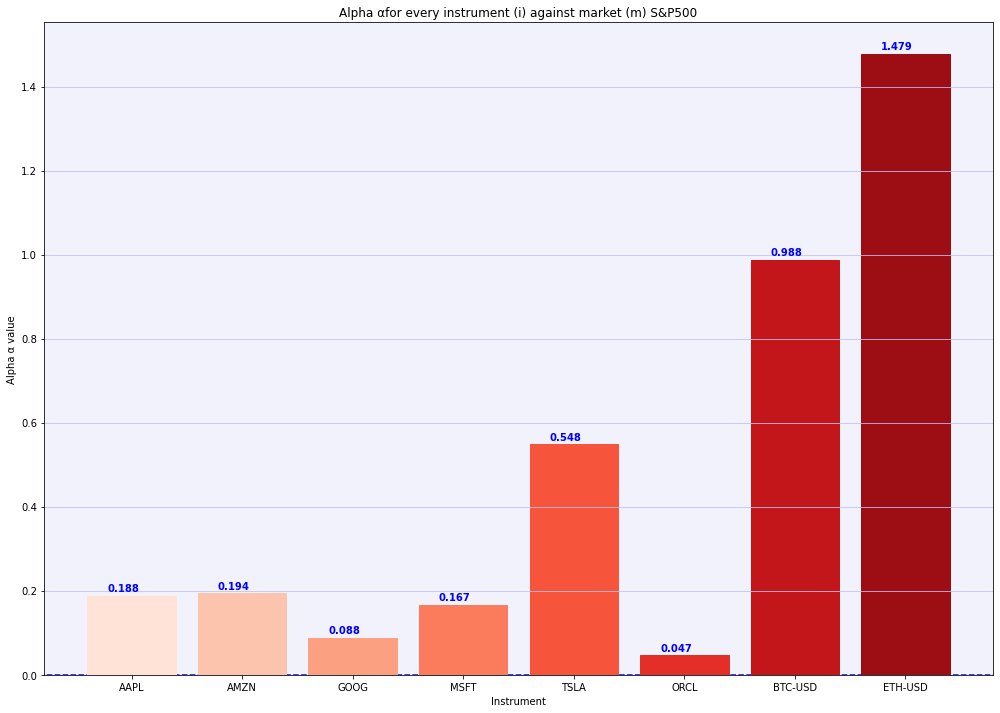

In [32]:
visualize_statistic(alpha.values, "Alpha α")

In [33]:
pd.DataFrame(beta,  columns = ["Average β"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average β,1.31684,1.034352,1.195334,1.278752,1.465348,1.026928,0.545415,0.791881


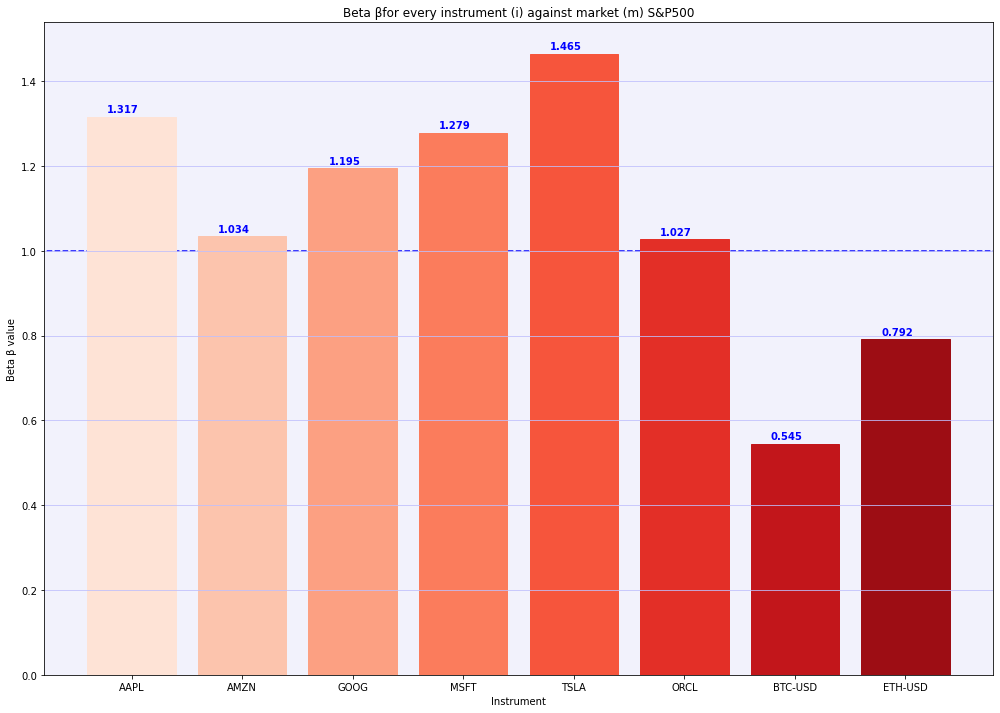

In [34]:
visualize_statistic(beta.values, "Beta β", limit = 1)

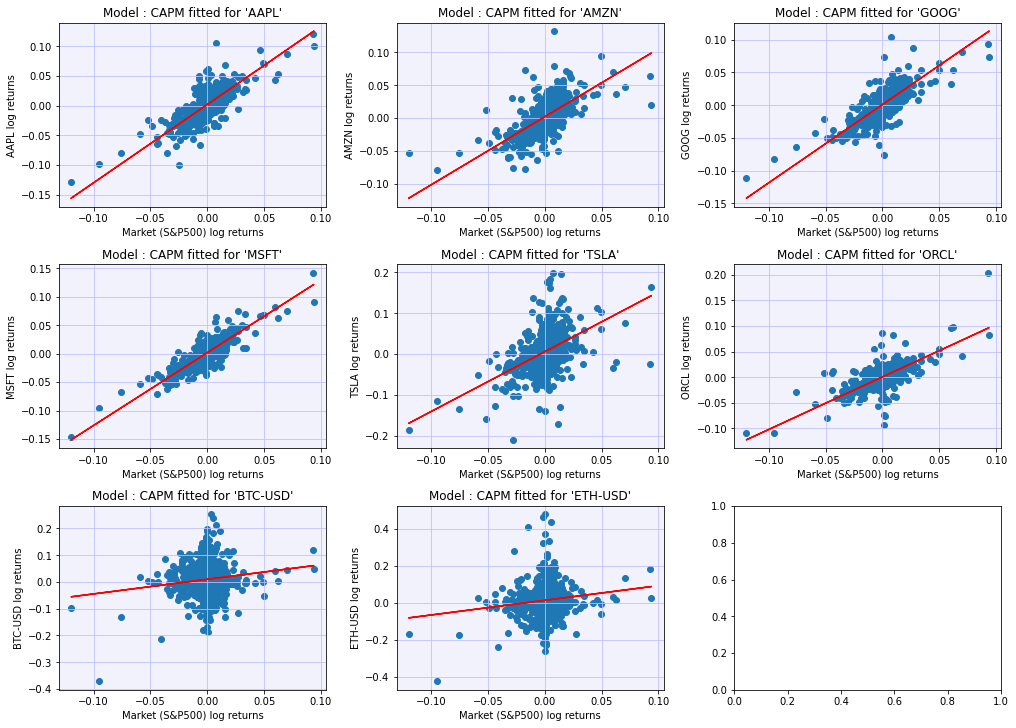

In [35]:
# Visualize data and CAPM model
visualize_model(alpha/100, beta, data = log_returns_total.copy(), model = 'CAPM')

### Apply Linear Regression Model (OLS) $y = \alpha + \beta x$

In [36]:
beta_reg, alpha_reg = np.polyfit(x = log_returns_total['^GSPC'], y = log_returns_total[log_returns.columns], deg = 1)

pd.DataFrame(alpha_reg,  index = log_returns.columns ,columns = ["Average α"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average α,0.000918,0.000982,0.000462,0.000801,0.002625,0.000273,0.004825,0.007135


In [37]:
pd.DataFrame(beta_reg,  index = log_returns.columns ,columns = ["Average β"]).T

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Average β,1.194428,0.926626,1.066026,1.195225,1.31764,0.935126,0.471377,0.697625


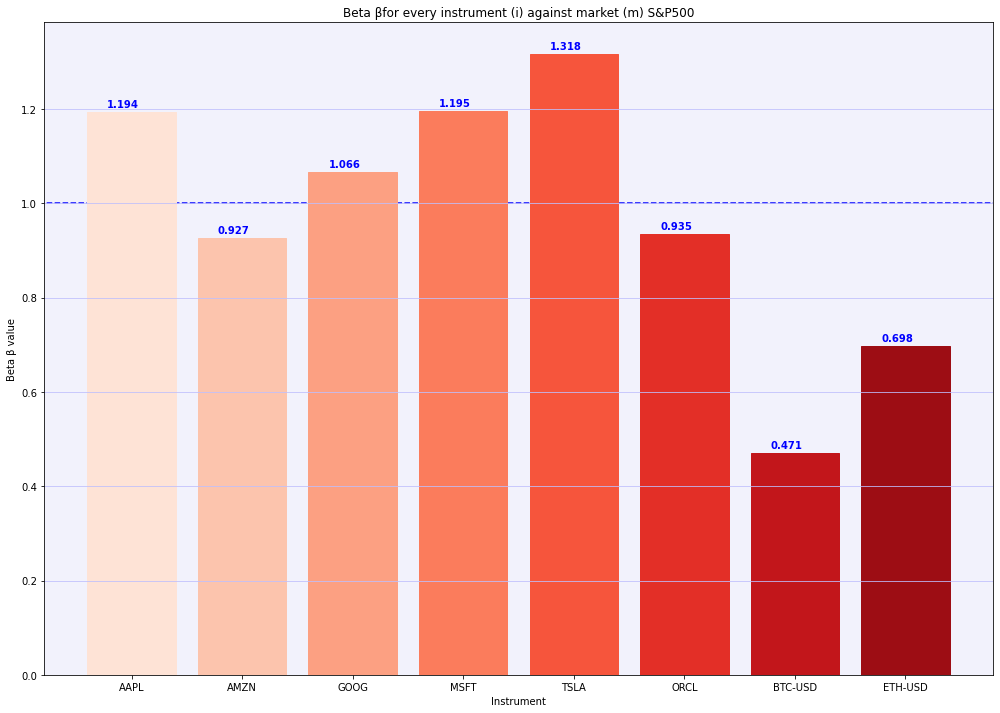

In [38]:
visualize_statistic(beta_reg, "Beta β", limit = 1)

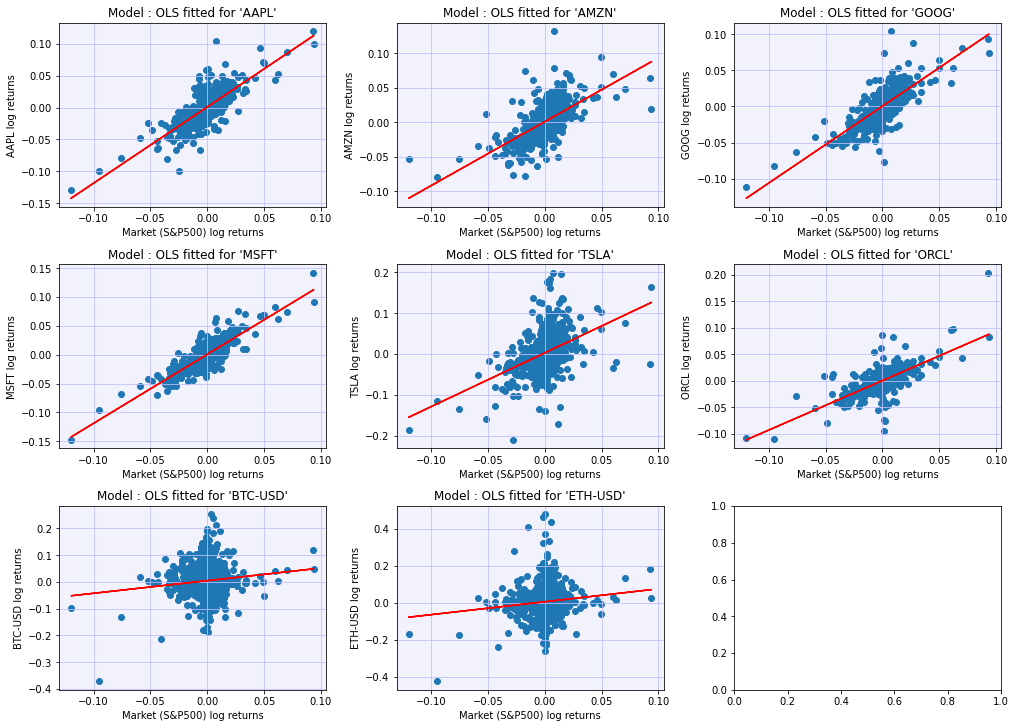

In [39]:
# Visualize data and OLS model
visualize_model(alpha_reg, beta_reg, data = log_returns_total.copy(), model = 'OLS')

In [40]:
portfolios = {
    "#1 dummy (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},          
    "#1 dummy (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}, 
    "#2 optimized max sr (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized max sr (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized min σ (risky)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0},
    "#2 optimized min σ (total)" : {"Return E[R]" : 0, "Risk σ" : 0, "Sharpe Ratio SR" : 0}
}

### Portfolio #1 (the dummy portfolio)

In [41]:
# WEIGHTS, RETURN, RISK
cov = APR.cov()
weights = np.array([ 0.8/ 6] * 6  + [ 0.1 / 2] * 2)
expected_return = np.sum(APR_avg * weights)
expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 

# RISKY PORTFOLIO
portfolios["#1 dummy (risky)"]["Return E[R]"]     = expected_return
portfolios["#1 dummy (risky)"]["Risk σ"]          = expected_risk
portfolios["#1 dummy (risky)"]["Sharpe Ratio SR"] = (expected_return - risk_free) / expected_risk

# TOTAL PORTFOLIO
total_expected_return = 0.9 * expected_return + 0.1 * risk_free
total_expected_risk   = 0.9 * expected_risk
portfolios["#1 dummy (total)"]["Return E[R]"]     = total_expected_return
portfolios["#1 dummy (total)"]["Risk σ"]          = total_expected_risk
portfolios["#1 dummy (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk

portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.408804,0.370857,1.013341
#1 dummy (total),0.371224,0.333771,1.013341
#2 optimized max sr (risky),0.000000,0.000000,0.000000
#2 optimized max sr (total),0.000000,0.000000,0.000000
#2 optimized min σ (risky),0.000000,0.000000,0.000000
#2 optimized min σ (total),0.000000,0.000000,0.000000


### Portfolio #2 (the optimized portfolio)

In [42]:
# Portfolio Simulation
num_portfolios = 10000
generated_portfolios = []

for idx in range(num_portfolios):
    # select random weights for portfolio holdings & rebalance weights to sum to 1
    weights = np.array(np.random.random(8))
    weights /= np.sum(weights)

    # calculate return, risk, sharpe ratio
    expected_return = np.sum(APR_avg * weights)
    expected_risk   = np.sqrt( np.dot(weights.T , np.dot(cov, weights)) ) 
    sharpe_ratio    = ( expected_return - risk_free) / expected_risk

    # store the result
    generated_portfolios.append([ expected_return, expected_risk, sharpe_ratio, weights] )

# Locate the 2 'special' portfolios 1) maximum sharpe ratio 2) minimum risk
maximum_sr_portfolio   = sorted(generated_portfolios, key = lambda x : -x[2])[0]
minimum_risk_portfolio = sorted(generated_portfolios, key = lambda x : x[1])[0]
max_sr = maximum_sr_portfolio[2]

max_sr_weights = pd.DataFrame(maximum_sr_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized max sr "]).T
min_risk_weights = pd.DataFrame(minimum_risk_portfolio[3], index = log_returns.columns ,columns = ["Optimal Weights  #2 optimized min σ "]).T

In [43]:
max_sr_weights

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Optimal Weights #2 optimized max sr,0.087447,0.000195,0.270469,0.364016,0.026479,0.241266,0.00364,0.006489


In [44]:
min_risk_weights

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL,BTC-USD,ETH-USD
Optimal Weights #2 optimized min σ,0.087447,0.000195,0.270469,0.364016,0.026479,0.241266,0.00364,0.006489


In [45]:
# RISKY PORTFOLIOS
portfolios["#2 optimized max sr (risky)"]["Return E[R]"]     = maximum_sr_portfolio[0]
portfolios["#2 optimized max sr (risky)"]["Risk σ"]          = maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (risky)"]["Sharpe Ratio SR"] = (maximum_sr_portfolio[0] - risk_free) / maximum_sr_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Return E[R]"]      = minimum_risk_portfolio[0]
portfolios["#2 optimized min σ (risky)"]["Risk σ"]           = minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (risky)"]["Sharpe Ratio SR"]  = (minimum_risk_portfolio[0] - risk_free) / minimum_risk_portfolio[1]

# TOTAL PORTFOLIOS
total_expected_return = 0.9 * maximum_sr_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * maximum_sr_portfolio[1]
portfolios["#2 optimized max sr (total)"]["Return E[R]"]     = total_expected_return
portfolios["#2 optimized max sr (total)"]["Risk σ"]          = total_expected_risk
portfolios["#2 optimized max sr (total)"]["Sharpe Ratio SR"] = (total_expected_return - risk_free) / total_expected_risk
total_expected_return = 0.9 * minimum_risk_portfolio[0] + 0.1 * risk_free
total_expected_risk   = 0.9 * minimum_risk_portfolio[1]
portfolios["#2 optimized min σ (total)"]["Return E[R]"]      = total_expected_return
portfolios["#2 optimized min σ (total)"]["Risk σ"]           = total_expected_risk
portfolios["#2 optimized min σ (total)"]["Sharpe Ratio SR"]  = (total_expected_return - risk_free) / total_expected_risk

In [46]:
portfolios_df = pd.DataFrame(portfolios).T
portfolios_df

,Return E[R],Risk σ,Sharpe Ratio SR
#1 dummy (risky),0.408804,0.370857,1.013341
#1 dummy (total),0.371224,0.333771,1.013341
#2 optimized max sr (risky),0.278144,0.175896,1.393686
#2 optimized max sr (total),0.253629,0.158306,1.393686
#2 optimized min σ (risky),0.278144,0.175896,1.393686
#2 optimized min σ (total),0.253629,0.158306,1.393686


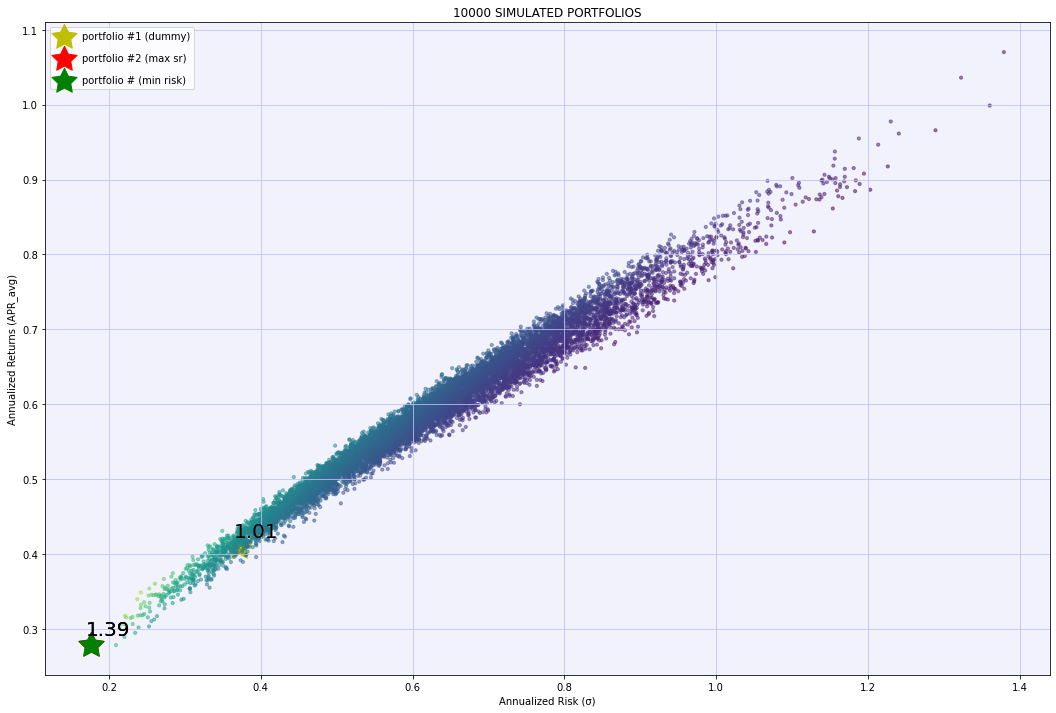

In [47]:
# plot the 2 optimized portfolios along with the rest 9998
def plot_simulation(CAL = None, INSTRUMENTS = None):
    fig, ax = plt.subplots(figsize = (18, 12))
    ax.set_facecolor((0.95, 0.95, 0.99))
    ax.grid(c = (0.75, 0.75, 0.99))
    
    # portfolio #1
    ret  = portfolios["#1 dummy (risky)"]["Return E[R]"]
    risk = portfolios["#1 dummy (risky)"]["Risk σ"]
    sr   = (ret - risk_free) / risk
    ax.scatter(risk, ret, marker = (5,1,0), color = 'y', s = 700, label = 'portfolio #1 (dummy)')
    ax.annotate(round(sr, 2), (risk - 0.006, ret + 0.013),  fontsize = 20, color = 'black')
 
    # portfolio #2
    ret, risk, sr = [x[0] for x in generated_portfolios], [x[1] for x in generated_portfolios], [x[2] for x in generated_portfolios]
    ax.scatter(risk, ret, c = sr, cmap = 'viridis', marker = 'o', s = 10, alpha = 0.5)
    ax.scatter(maximum_sr_portfolio[1], maximum_sr_portfolio[0],marker = (5,1,0),color = 'r',s = 700, label = 'portfolio #2 (max sr)')
    ax.annotate(round(maximum_sr_portfolio[2], 2), (maximum_sr_portfolio[1]  - 0.006,maximum_sr_portfolio[0] + 0.013), fontsize = 20, color = 'black')
    ax.scatter(minimum_risk_portfolio[1], minimum_risk_portfolio[0], marker = (5,1,0), color = 'g',s = 700,  label = 'portfolio # (min risk)')
    ax.annotate(round(minimum_risk_portfolio[2], 2), (minimum_risk_portfolio[1]  - 0.006,minimum_risk_portfolio[0] + 0.013), fontsize = 20, color = 'black')

    if INSTRUMENTS : 
        ax.scatter(STD_avg, APR_avg, s = s , c = c , cmap = "Blues", alpha = 0.4, edgecolors = "grey", linewidth = 2)
        for idx, instr in enumerate(list(STD.columns)):
            sr = round((APR_avg[idx] - risk_free) / STD_avg[idx] , 2)
            ax.annotate(instr, (STD_avg[idx] + 0.01, APR_avg[idx]))
            ax.annotate(sr, (STD_avg[idx] - 0.005 , APR_avg[idx] + 0.015))

    ax.set_title('10000 SIMULATED PORTFOLIOS')
    ax.set_xlabel('Annualized Risk (σ)')
    ax.set_ylabel('Annualized Returns (APR_avg)')
    ax.legend(labelspacing = 1.2)

plot_simulation()

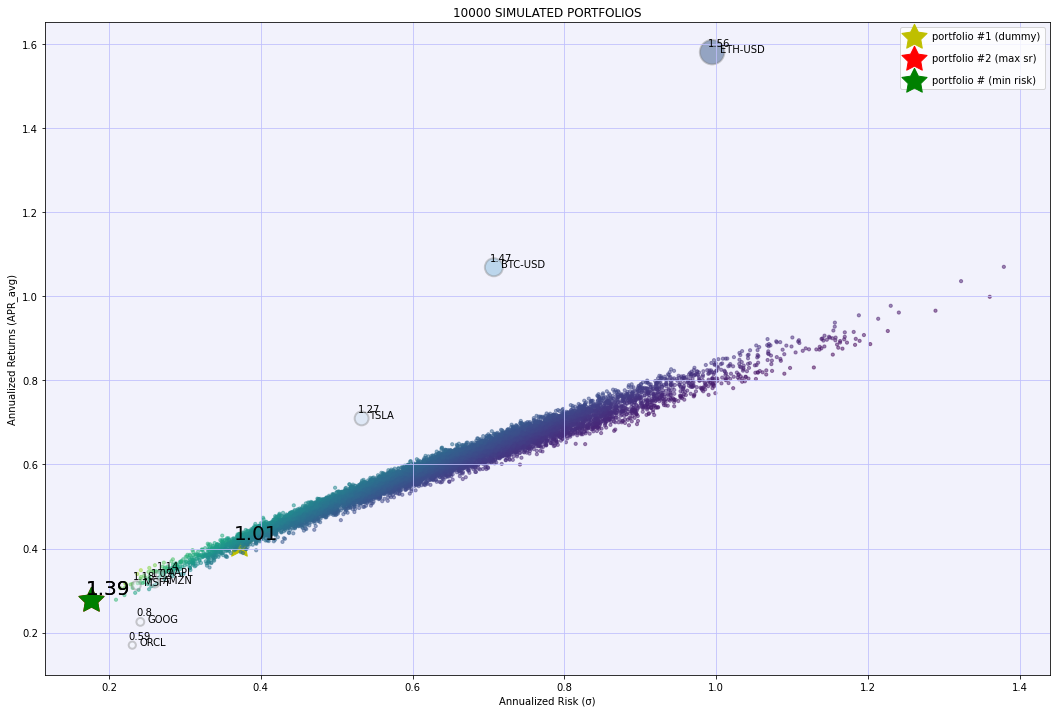

In [48]:
plot_simulation(CAL = None, INSTRUMENTS = 'yes')

### Utility Function
$$U = E[r] - \frac{1}{2}A\sigma^2$$

In [49]:
A = np.linspace(0, 10, 10)
utility_dummy    = portfolios["#1 dummy (total)"]["Return E[R]"] - 1/2 * A * portfolios["#1 dummy (total)"]["Risk σ"] ** 2
utility_max_sr   = portfolios["#2 optimized max sr (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized max sr (total)"]["Risk σ"] ** 2
utility_min_risk = portfolios["#2 optimized min σ (total)"]["Return E[R]"] - 1/2 * A * portfolios["#2 optimized min σ (total)"]["Risk σ"] ** 2

In [50]:
# Final Evaluation
portfolio = portfolios["#2 optimized max sr (total)"]
ret       = portfolio['Return E[R]']
risk      = portfolio['Risk σ']
sr        = portfolio['Sharpe Ratio SR']
utility   = ret - 1/2 * 3 * risk ** 2

portfolio = pd.DataFrame([str(round(ret * 100, 2)) + "%", str(round(risk * 100, 2)) + "%", sr, str(round(utility * 100, 2) ) + "%"], index = ['Return E[R]', 'Risk σ', 'Sharpe Ratio SR', 'Utility U'] ,columns = ["Portfolio #2 optimized max sr "]).T
portfolio

,Return E[R],Risk σ,Sharpe Ratio SR,Utility U
Portfolio #2 optimized max sr,25.36%,15.83%,1.39369,21.6%


In [51]:
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs

In [52]:
tech_list = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA', 'ORCL']
today = datetime.now()
stockStartDate = datetime(2019, 1, 1)
# Create a dateframe to store the adjusted close price of the stocks
df = pd.DataFrame()

for stock in tech_list:
    df[stock] = DataReader(stock, data_source='yahoo', start=stockStartDate, end = today)['Adj Close']      
df.to_csv("techlist1.csv")


df = pd.read_csv(r'..\UPGRADE\techlist1.csv')
df.head()

,Date,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL
0,2019-01-02,38.505024,1539.130005,1045.849976,98.375481,62.023998,43.526508
1,2019-01-03,34.669640,1500.280029,1016.059998,94.756454,60.071999,43.102985
2,2019-01-04,36.149662,1575.390015,1070.709961,99.163513,63.537998,44.960709
3,2019-01-07,36.069202,1629.510010,1068.390015,99.289970,66.991997,45.673000
4,2019-01-08,36.756794,1656.579956,1076.280029,100.009888,67.070000,46.086891


In [53]:
df = pd.read_csv(r'..\UPGRADE\techlist1.csv')

df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')

# Select the proper time period for daily aggreagation
# When mean() problem, because NAN shares on weekends(miss data)
# df = df['2016-01-02':'2020-12-05'].resample('D').sum()
df.head()

# df=df.dropna()
# pd.isnull(df).sum()

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL
Date,,,,,,
2019-01-02,38.505024,1539.130005,1045.849976,98.375481,62.023998,43.526508
2019-01-03,34.669640,1500.280029,1016.059998,94.756454,60.071999,43.102985
2019-01-04,36.149662,1575.390015,1070.709961,99.163513,63.537998,44.960709
2019-01-07,36.069202,1629.510010,1068.390015,99.289970,66.991997,45.673000
2019-01-08,36.756794,1656.579956,1076.280029,100.009888,67.070000,46.086891


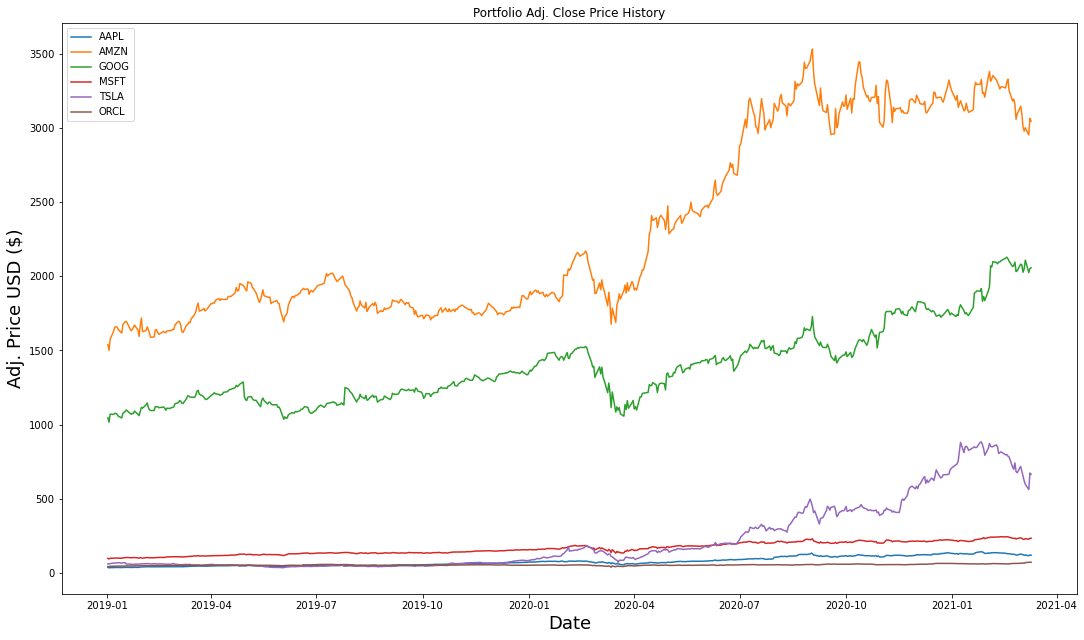

In [54]:
# Vizually show the stock/portfolio
title = 'Portfolio Adj. Close Price History'

# Get the stocks
my_stocks = df

# Create and plot the graph
plt.figure(figsize=(18.2, 10.5))
for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label = c)

    

# plt.plot(df)
plt.title(title)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj. Price USD ($)', fontsize = 18)
plt.legend(my_stocks.columns.values, loc = 'upper left')
plt.show()

In [55]:
# Show the daily simple return
returns = df.pct_change()
returns

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.099607,-0.025242,-0.028484,-0.036788,-0.031472,-0.009730
2019-01-04,0.042689,0.050064,0.053786,0.046509,0.057697,0.043100
2019-01-07,-0.002226,0.034353,-0.002167,0.001275,0.054361,0.015843
2019-01-08,0.019063,0.016612,0.007385,0.007251,0.001164,0.009062
...,...,...,...,...,...,...
2021-03-04,-0.015812,-0.009128,0.011043,-0.003647,-0.048622,-0.019429
2021-03-05,0.010738,0.007687,0.029013,0.021479,-0.037799,0.066453
2021-03-08,-0.041674,-0.016168,-0.040013,-0.018178,-0.058450,0.031299


In [56]:
# Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,AAPL,AMZN,GOOG,MSFT,TSLA,ORCL
AAPL,0.141661,0.079666,0.082493,0.098871,0.125089,0.067859
AMZN,0.079666,0.098487,0.065885,0.076745,0.098924,0.045431
GOOG,0.082493,0.065885,0.103590,0.084777,0.091730,0.056277
MSFT,0.098871,0.076745,0.084777,0.111897,0.112332,0.071295
TSLA,0.125089,0.098924,0.091730,0.112332,0.531118,0.047934
ORCL,0.067859,0.045431,0.056277,0.071295,0.047934,0.099742


In [57]:
# Assign weights to the stocks.
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.13988458501880408

In [58]:
# Calculate the portfolio volatility aka standart deviation
port_volatility = np.sqrt(port_variance)
port_volatility

0.37401147712176436

In [59]:
# Calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.6811600765196653

In [60]:
# Show the expected annual return, volatility(RISK), variance

percent_var = str(round(port_variance, 2) * 100) + '%'
percent_vols = str(round(port_volatility, 2) * 100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + '%'

print('Expected annual return: '+ percent_ret)
print('Annual volatility/risk: '+ percent_vols)
print('Annual variance: '+ percent_var)

Expected annual return: 68.0%
Annual volatility/risk: 37.0%
Annual variance: 14.000000000000002%


In [61]:
# pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [62]:
# Portfolio optimization

# Calculate the expected returns and the annualised sample covariance matrix of assets returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for max sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('AAPL', 0.35958), ('AMZN', 0.0), ('GOOG', 0.0), ('MSFT', 0.0), ('TSLA', 0.64042), ('ORCL', 0.0)])
Expected annual return: 150.5%
Annual volatility: 54.2%
Sharpe Ratio: 2.74


(1.5052104997525875, 0.5419941529088218, 2.7402703364632797)

In [63]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation {'AAPL': 45, 'TSLA': 14}
Funds remaining: $282.42
